In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
def add_intercept(x):
    """
      Dùng cho tất cả các bài trong file

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', bias=False):
    """
    Dùng cho dataset ds1_train
    """


    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if bias:
        inputs = add_intercept(inputs)

    return inputs, labels

#I. Logistic Regression

Trong các bài học trước, ta đã được học về mô hình **Hồi quy Tuyến tính (Linear Regression)**, mô hình này hoạt động hiệu quả khi **biến đầu ra (target)** là **liên tục** — chẳng hạn như dự đoán giá nhà, chiều cao, cân nặng,... Tuy nhiên, khi ta cần **phân loại** (ví dụ: email có phải spam hay không, bệnh nhân mắc bệnh hay không), thì **Linear Regression không còn phù hợp**.

Vì vậy, ta cần một mô hình khác — **Logistic Regression**, được thiết kế cho **phân loại nhị phân**. Logistic Regression vẫn giữ phần **kết hợp tuyến tính** của đặc trưng đầu vào, nhưng sử dụng **hàm logistic (sigmoid)** để **nén đầu ra** về khoảng $[0,1]$, giúp diễn giải trực tiếp như **xác suất**.


Gợi nhắc lại mô hình hồi quy tuyến tính, ta có:
$$
h_{\theta}(x)= \theta_0 + \theta_1 x_1 + \ldots \theta_n x_n
$$

hay

$$
h(x)= \sum_{i=0}^{n} \theta_i x_i = \theta^{T}x
$$

Trong bài toán phân loại, ta không thể sử dụng trực tiếp Linear Regression để dự đoán nhãn ví dụ như $y \in \{0,1\}$. Lý do là vì đầu ra của mô hình tuyến tính có thể lớn hơn 1 hoặc nhỏ hơn 0, trong khi ta cần một giá trị biểu diễn **xác suất.**

Để khắc phục vấn đề này, ta thay đổi dạng của giả thuyết $h_{\theta}(x)$ sao cho giá trị đầu ra luôn nằm trong khoảng $[0,1]$ bằng cách:

$$
h_{\theta}(x) = g(\theta^Tx)
$$

với $g(z)$ là hàm logistic (sigmoid function) được định nghĩa như sau:
$$
g(z) = \frac{1}{1 + e^{-z}}
$$



In [3]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

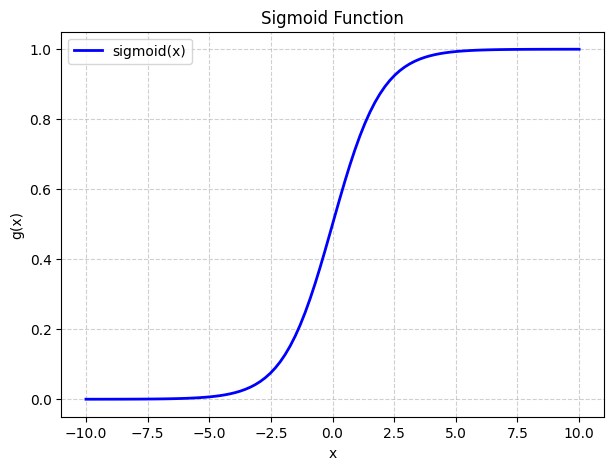

In [4]:
x = np.linspace(-10, 10, 100)
y = sigmoid(x)

plt.figure(figsize=(7, 5))
plt.plot(x, y, color='blue', linewidth=2, label='sigmoid(x)')
plt.title("Sigmoid Function")
plt.xlabel("x")
plt.ylabel("g(x)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Từ hình vẽ bên trên, ta có thể thấy khi $g(z)$ tiến tới $1$ khi $z \to \infty$, và $g(z)$ tiến tới $0$ khi $z \to -\infty$. Do đó, $g(z)$, và cả $h(\mathbf{x})$, luôn bị chặn giữa $0$ và $1$. Như với mô hình Linear Regression trong bài trước, chúng ta vẫn giữ quy ước đặt $x_0 = 1$, sao cho
$$\boldsymbol{\theta}^T \mathbf{x} = \theta_0 + \sum_{j=1}^n \theta_j x_j.$$

Nhờ đặc tính của hàm sigmoid, đầu ra của Hồi quy Logistic (Logistic Regression) có thể được diễn giải như là **xác suất** mà mẫu $\mathbf{x}$ thuộc về lớp $1$:

$$P(y=1|\mathbf{x};\boldsymbol{\theta}) = h_{\boldsymbol{\theta}}(\mathbf{x}) = g(\boldsymbol{\theta}^T \mathbf{x})$$

Ngược lại, xác suất mẫu $\mathbf{x}$ thuộc về lớp $0$ sẽ là:

$$P(y=0|\mathbf{x};\boldsymbol{\theta}) = 1 - h_{\boldsymbol{\theta}}(\mathbf{x})$$

Dựa trên hai xác suất trên, chúng ta có thể viết gọn công thức xác suất cho cả hai trường hợp $y \in \{0, 1\}$ thành một biểu thức duy nhất:

$$P(y|\mathbf{x};\boldsymbol{\theta}) = h_{\boldsymbol{\theta}}(\mathbf{x})^{y}(1-h_{\boldsymbol{\theta}}(\mathbf{x}))^{1-y}$$

Giả sử có $m$ ví dụ huấn luyện $(\mathbf{x}^{(i)}, y^{(i)})$ được tạo ra **độc lập và phân phối đồng nhất (I.I.D)**. **Hàm Hợp Lý** $L(\boldsymbol{\theta})$ là tích của xác suất của tất cả các ví dụ:

$$L(\boldsymbol{\theta}) = P(\mathbf{y}|\mathbf{X}; \boldsymbol{\theta}) = \prod_{i=1}^{m} P(y^{(i)}|\mathbf{x}^{(i)}; \boldsymbol{\theta})$$

Thay công thức xác suất gộp vào:

$$L(\boldsymbol{\theta}) = \prod_{i=1}^{m} \left( h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) \right)^{y^{(i)}} \left( 1 - h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) \right)^{1-y^{(i)}}$$


Để việc tối ưu hóa và lấy đạo hàm thuận tiện hơn, chúng ta chuyển sang **Hàm Log-Hợp Lý** $\ell(\boldsymbol{\theta}) = \log L(\boldsymbol{\theta})$:

$$\ell(\boldsymbol{\theta}) = \sum_{i=1}^{m} \left[ y^{(i)} \log \left( h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) \right) + (1 - y^{(i)}) \log \left( 1 - h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) \right) \right]$$

Chúng ta định nghĩa **Hàm Chi Phí** $J(\boldsymbol{\theta})$ (còn gọi là **Cross-Entropy Loss** hoặc **Log Loss**) là **âm** của Log-Hợp Lý, chia cho $m$ để lấy chi phí trung bình:

$$J(\boldsymbol{\theta}) = - \frac{1}{m} \ell(\boldsymbol{\theta})$$

$$J(\boldsymbol{\theta}) = - \frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log \left( h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) \right) + (1 - y^{(i)}) \log \left( 1 - h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) \right) \right]$$

#II. Gradient Descent cho Logistic Regression

Trong Hồi quy Tuyến tính, Gradient Descent có dạng (sử dụng hàm mất mát bình phương trung bình - Mean Squared Error):

**Quy tắc cập nhật tham số $\boldsymbol{\theta}$:**
$$\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m} \left( h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) - y^{(i)} \right) x_j^{(i)}$$

***

Trong **Hồi quy Logistic**, Gradient Descent được sử dụng để **tối thiểu hóa (Minimize) Hàm Chi Phí Cross-Entropy (Log Loss)** $J(\boldsymbol{\theta})$.

### 1. Hàm Chi Phí (Cost Function)
$$J(\boldsymbol{\theta}) = - \frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log \left( h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) \right) + (1 - y^{(i)}) \log \left( 1 - h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) \right) \right]$$

Trong đó $h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) = g(\boldsymbol{\theta}^T \mathbf{x}^{(i)}) = \frac{1}{1 + e^{-\boldsymbol{\theta}^T \mathbf{x}^{(i)}}}$.

### 2. Đạo hàm (Gradient)
Đạo hàm riêng của hàm chi phí $J(\boldsymbol{\theta})$ theo tham số $\theta_j$ là:
$$\frac{\partial}{\partial \theta_j} J(\boldsymbol{\theta}) = \frac{1}{m} \sum_{i=1}^{m} \left( h_{\boldsymbol{\theta}}(\mathbf{x}^{(i)}) - y^{(i)} \right) x_j^{(i)}$$

hay:

$$
\nabla_{\theta} J(\theta) = \frac{1}{m}  X^T (h - y)
$$

### 3. Quy tắc Cập nhật Gradient Descent
Quy tắc cập nhật cho từng tham số $\theta_j$ (với $\alpha$ là tốc độ học):

$$\theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\boldsymbol{\theta})$$

Thay đạo hàm vào, ta được quy tắc cập nhật Gradient Descent cho **Hồi quy Logistic**:

$$\theta_j := \theta_j - \alpha \frac{1}{m}  X^T (h - y)$$

**Lưu ý quan trọng:**

Mặc dù quy tắc cập nhật của Logistic Regression **trông giống hệt** Linear Regression, chúng là hai thuật toán khác nhau vì hàm giả thuyết $h_{\boldsymbol{\theta}}(\mathbf{x})$ được định nghĩa khác:

* **Linear Regression:** $h_{\boldsymbol{\theta}}(\mathbf{x}) = \boldsymbol{\theta}^T \mathbf{x}$ (Tuyến tính)
* **Logistic Regression:** $h_{\boldsymbol{\theta}}(\mathbf{x}) = g(\boldsymbol{\theta}^T \mathbf{x})$ (Phi tuyến tính, sử dụng hàm Sigmoid)

In [6]:
ds1_training_set_path = '/content/Lab 5/ds1_train.csv'
ds1_valid_set_path = '/content/Lab 5/ds1_valid.csv'

x_train, y_train = load_dataset(ds1_training_set_path, bias=True)
x_valid, y_valid = load_dataset(ds1_valid_set_path, bias=True)

FileNotFoundError: [Errno 2] No such file or directory: '/content/Lab 5/ds1_train.csv'

# **Bài tập 1:** Hoàn thiện class `SimpleLogisticRegression`



In [ ]:
class SimpleLogisticRegression(object):
    def __init__(self, alpha=0.1, eps=1e-6, max_iter=1000, verbose: bool = False):
        self.theta = None
        self.alpha = alpha
        self.eps = eps
        self.max_iter = max_iter
        self.verbose = verbose

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, X, y):
        m = len(y)
        # TODO: 1. Tính h sử dụng hàm sigmoid.
        h = self.sigmoid(X @ self.theta)
        # TODO: 2. Áp dụng công thức Log Loss
        loss = - (1 / m) * np.sum(y * np.log(h + self.eps) + (1 - y) * np.log(1 - h + self.eps))
        return loss

    def _gradient_descent(self, X, y):
        m = len(y)
        # TODO: 1. Tính xác suất dự đoán h.
        h = self.sigmoid(X @ self.theta)
        # TODO: 2. Tính sai số.
        error = h - y
        # TODO: 3. Tính Gradient.
        grad = (1 / m) * (X.T @ error)
        return grad
        # TODO: 4. Cập nhật theta: new_theta = self.theta - self.alpha * grad.
        new_theta = self.theta - self.alpha * grad
        # TODO: Trả về new_theta.
        return new_theta

    def fit(self, X, y):
        m, n_features = X.shape
        # TODO: 1. Khởi tạo self.theta bằng vector zero (kích thước n_features).
        self.theta = np.zeros(n_features)
        for i in range(self.max_iter):

            # TODO: 2. Lấy new_theta bằng cách gọi self._gradient_descent_step().
            new_theta = self._gradient_descent(X, y)
            # TODO: 3. KIỂM TRA HỘI TỤ (Convergence Check):
            # Dùng np.linalg.norm(new_theta - self.theta, 1) < self.eps.
            # Nếu hội tụ, cập nhật self.theta và kết thúc (return).
            if np.linalg.norm(new_theta - self.theta, 1) < self.eps:
                self.theta = new_theta
                return
            # TODO: 4. Cập nhật self.theta = new_theta.
            self.theta = new_theta
            # TODO: 5. (Tùy chọn) In thông tin mất mát (loss) nếu self.verbose là True.
            if self.verbose and i % 100 == 0:
                loss = self.compute_loss(X, y)
                print(f"Iteration {i}: Loss = {loss}")
            pass

    def predict(self, X):
        # TODO: 1. Tính xác suất dự đoán prob = self.sigmoid(X @ self.theta).
        prob = self.sigmoid(X @ self.theta)
        # TODO: 2. Áp dụng ngưỡng (threshold) 0.5 để đưa ra nhãn cuối cùng (0 hoặc 1).
        # Gợi ý: Dùng phép so sánh và .astype(int).
        return (prob >= 0.5).astype(int)
        pass

In [ ]:
# Sau khi hoàn thiện class trên thì uncomment các dòng dưới đây,
# Cho phép điều chỉnh lại các hyper-parameters theo ý thích của mình.

model = SimpleLogisticRegression(alpha=0.001, max_iter=10000, verbose=True)
model.fit(x_train, y_train)
learned_theta = model.theta

NameError: name 'x_train' is not defined

In [ ]:
print("\nLearned Parameters (theta):")
print(learned_theta)


Learned Parameters (theta):
[-0.47080079  0.70797107 -0.02234002]


In [ ]:
y_pred = model.predict(x_valid)
accuracy = np.mean(y_pred == y_valid)
print(f"\nFinal Accuracy on Valid Data: {accuracy:.2f}")


Final Accuracy on Training Data: 0.80


# III. Phương pháp Newton cho Logistic Regression

Ngoài Gradient Descent, ta còn một phương pháp khác để tối ưu hóa Logistic Regression là sử dụng phương pháp Newton để tìm nghiệm của hàm đạo hàm của hàm mục tiêu.

Để bắt đầu, chúng ta hãy xem xét **phương pháp Newton** để tìm nghiệm của một hàm. Cụ thể, giả sử chúng ta có một hàm $f : \mathbb{R} \mapsto \mathbb{R}$, và chúng ta muốn tìm một giá trị $\theta$ sao cho $f(\theta) = 0$. Ở đây, $\theta \in \mathbb{R}$ là một số thực. Phương pháp Newton thực hiện cập nhật sau:
$$\theta := \theta - \frac{f(\theta)}{f'(\theta)}$$

Phương pháp này có một cách giải thích tự nhiên, trong đó chúng ta có thể coi nó là việc xấp xỉ hàm $f$ bằng một hàm tuyến tính tiếp tuyến với $f$ tại giá trị đoán hiện tại $\theta$, giải phương trình để tìm nơi hàm tuyến tính đó bằng không, và để giá trị đoán tiếp theo cho $\theta$ là nơi hàm tuyến tính đó bằng `0`.

Bằng cách đặt $f(\theta) = \ell'(\theta)$, chúng ta có thể sử dụng cùng một thuật toán để tối đa hóa $\ell$, và ta nhận được quy tắc cập nhật:

$$\theta := \theta - \frac{\ell'(\theta)}{\ell''(\theta)}$$

hay:
$$
\theta := \theta - H^{-1}\nabla_{\theta}\ell(\theta)
$$


biết:
$$
H = X^T W X
$$
- Trong đó:
  - W là Ma trận Đường chéo (m x m).
  - Các phần tử trên đường chéo là:
  - $W_{ii} = h_i (1 - h_i)$


Dựa trên hai công thức ở trên, hãy xây dựng một funciton hoặc một class để xử lý Logistic Regression sử dụng phương pháp Newton

# **Bài tập 2:** Hoàn thiện class `LogisticNewtonMethod`

In [ ]:
class LogisticNewtonMethod(object):
    def __init__(self, eps=1e-6, max_iter=100, verbose: bool = False):
        self.theta = None
        self.eps = eps
        self.max_iter = max_iter
        self.verbose = verbose

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, X, y):
        m = len(y)
        # TODO: 1. Tương tự Bt1
        h = self.sigmoid(X @ self.theta)
        loss = - (1 / m) * np.sum(y * np.log(h + self.eps) + (1 - y) * np.log(1 - h + self.eps))
        return loss
        pass
    def hessian(self, X):
        m, n_features = X.shape
        # TODO: 1. Tính h.
        h = self.sigmoid(X @ self.theta)
        # TODO: 2. Tính vector w = h * (1 - h).
        w = h * (1 - h)
        # TODO: 3. Tạo ma trận đường chéo W từ vector w (np.diag(w)).
        W = np.diag(w)
        # TODO: 4. Tính toán và trả về ma trận Hessian.
        pass

    def fit(self, X, y):
        m, n_features = X.shape
        # TODO: 1. Khởi tạo self.theta bằng vector zero (kích thước n_features).
        self.theta = np.zeros(n_features)
        for i in range(self.max_iter):

            # TODO: 2. Tính Gradient:
            grad = self._gradient_descent(X, y)
            # TODO: 3. Tính Ma trận Hessian $H$ bằng cách gọi self.hessian(X).
            H = self.hessian(X)
            # TODO: 4. Tính nghịch đảo của Hessian: np.linalg.pinv.
            H_inv = np.linalg.pinv(H)
            # TODO: 5. Tính bước thay đổi H^(-1) @ grad.
            delta = H_inv @ grad

            # TODO: 6. Cập nhật theta.
            new_theta = self.theta - delta

            # TODO: 7. KIỂM TRA HỘI TỤ (Convergence Check):
            # Dùng np.linalg.norm(new_theta - self.theta, 1) < self.eps.
            # Nếu hội tụ, cập nhật self.theta và kết thúc (return).
            if np.linalg.norm(new_theta - self.theta, 1) < self.eps:
                self.theta = new_theta
                return

            # TODO: 8. Cập nhật self.theta = new_theta (có thể skip nếu đã update self.theta ở B6)
            self.theta = new_theta
            # TODO: 9. (Tùy chọn) In thông tin mất mát nếu self.verbose là True.
            if self.verbose:
                loss = self.compute_loss(X, y)
                print(f"Iteration {i + 1}: Loss = {loss:.4f}")

    def predict(self, X):
        # TODO: 1. Tính xác suất dự đoán prob.
        prob = self.sigmoid(X @ self.theta)
        # TODO: 2. Áp dụng ngưỡng 0.5 để đưa ra nhãn cuối cùng (0 hoặc 1).
        return (prob >= 0.5).astype(int)

In [ ]:
# Uncomment

model = LogisticNewtonMethod(max_iter=100, verbose=True)
model.fit(x_train, y_train)
learned_theta_newton = model.theta

Iter    1: Loss = 0.411776
Iter    2: Loss = 0.343864
Iter    3: Loss = 0.327153
Iter    4: Loss = 0.325591
Iter    5: Loss = 0.325572
Iter    6: Loss = 0.325572
Converged after 7 iterations. Final Loss = 0.325572
Final Theta: [-6.26018491  2.47707251 -0.0299125 ]


In [ ]:
y_pred = model.predict(x_valid)
accuracy = np.mean(y_pred == y_valid)
print(f"\nFinal Accuracy on Valid Data: {accuracy:.2f}")


Final Accuracy on Training Data: 0.88


In [ ]:
model = LogisticRegression(penalty=None, fit_intercept = False)
model.fit(x_train, y_train)

y_train_pred_sklearn = model.predict(x_valid)
accuracy_train_sklearn = accuracy_score(y_valid, y_train_pred_sklearn)

print(f"Accuracy on Valid Data: {accuracy_train_sklearn:.2f}")
print("\nLearned Parameters (sklearn):")
print("Coefficients:", model.coef_.flatten())

Accuracy on Training Data (sklearn Logistic Regression): 0.88

Learned Parameters (sklearn):
Coefficients: [-6.26018989  2.47707379 -0.0299125 ]


# **Bài tập 3:** Sử dụng hai phương pháp kể trên với bộ dữ liệu Titanic dataset

In [ ]:
df = pd.read_csv("/content/titanic.csv")

In [ ]:
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
target = "Survived"

df = df[features + [target]].copy()

In [ ]:
df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
df["Embarked"] = df["Embarked"].map({"S": 0, "C": 1, "Q": 2})

In [ ]:
X = df[features].values
y = df[target].values.astype(int)

In [ ]:
y = df[target].values.astype(int)

print("X shape:", X.shape)
print("y shape:", y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X shape: (891, 7)
y shape: (891,)


In [ ]:
median_age_train = np.nanmedian(X_train[:, features.index("Age")])
mode_embarked_train = np.nanmax(X_train[:, features.index("Embarked")])

In [ ]:
age_na_index = np.isnan(X_train[:, features.index("Age")])
embarked_na_index = np.isnan(X_train[:, features.index("Embarked")])
X_train[:, features.index("Age")][age_na_index] = median_age_train
X_train[:, features.index("Embarked")][embarked_na_index] = mode_embarked_train

age_na_index = np.isnan(X_test[:, features.index("Age")])
embarked_na_index = np.isnan(X_test[:, features.index("Embarked")])
X_test[:, features.index("Age")][age_na_index] = median_age_train
X_test[:, features.index("Embarked")][embarked_na_index] = mode_embarked_train

In [ ]:
X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

In [ ]:
X_train = add_intercept(X_train)
X_test  = add_intercept(X_test)

## Huấn luyện với hai mô hình tự implement ở trên và sklearn
- In ra accuracy của các mô hình trên tập test

In [ ]:
# SimpleLogisticRegression
model = SimpleLogisticRegression(alpha=0.1, max_iter=1000, verbose=True)
model.fit(X_train, y_train)
learned_theta_titanic = model.theta
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy on Titanic Test Data: {accuracy:.2f}")
print("\nLearned Parameters (theta) on Titanic Dataset:")
print(learned_theta_titanic) 

In [ ]:
# LogisticNewtonMethod
model = LogisticNewtonMethod(max_iter=100, verbose=True)
model.fit(X_train, y_train)
learned_theta_titanic_newton = model.theta
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy on Titanic Test Data (Newton's Method): {accuracy:.2f}")
print("\nLearned Parameters (theta) on Titanic Dataset (Newton's Method):")
print(learned_theta_titanic_newton)

In [ ]:
# sklearn
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty=None, fit_intercept = False)
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)

test_acc  = (y_pred_test  == y_test ).mean()

print(model.coef_)
print(f"Test Accuracy:  {test_acc:.4f}")

#V. Softmax Regression

Qua hai ví dụ trước, ta thấy Logistic Regression trong bài toán phân loại sử dụng Gradient Descent và Newton với hàm sigmoid bị giới hạn trong phân loại nhị phân với hai nhãn $y \in \{0,1\}$. Vậy nếu chúng ta muốn giải quyết các bài toán nơi có nhiều hơn 2 nhãn thì phải làm như thế nào ?



## 1. Hồi quy Softmax (Multinomial Logistic Regression)

Để mở rộng Logistic Regression từ phân loại nhị phân sang phân loại đa lớp ($K > 2$ nhãn), ta sử dụng **Hồi quy Softmax**. Phương pháp này thay thế hàm sigmoid bằng hàm Softmax và sử dụng một tập hợp các vector tham số $\mathbf{\theta}_1, \dots, \mathbf{\theta}_K$, mỗi vector tương ứng với một lớp.

### a. Hàm Softmax (Softmax Function)

Hàm Softmax tính toán xác suất $\hat{p}_k$ một mẫu $\mathbf{x}$ thuộc lớp $k$ trong tổng số $K$ lớp:

$$P(y=k \mid \mathbf{x} ; \mathbf{\Theta}) = \hat{p}_k = \frac{e^{\mathbf{\theta}_k^T \mathbf{x}}}{\sum_{j=1}^{K} e^{\mathbf{\theta}_j^T \mathbf{x}}}$$

Trong đó, $\mathbf{\Theta} = \{\mathbf{\theta}_1, \dots, \mathbf{\theta}_K\}$ là tập hợp tất cả các tham số của mô hình.

### b. Hàm Mất mát (Cost Function)

Hàm mất mát tiêu chuẩn là **Cross-Entropy Loss**:

$$J(\mathbf{\Theta}) = - \frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^{K} \mathbf{1}\{y^{(i)} = k\} \log(\hat{p}_k^{(i)})$$

$\mathbf{1}\{y^{(i)} = k\}$ là hàm chỉ thị, bằng $1$ nếu mẫu $i$ thuộc lớp $k$.

### c. Tối ưu hóa bằng Gradient Descent

Các tham số $\mathbf{\Theta}$ được tối ưu hóa thông qua **Gradient Descent** bằng cách sử dụng đạo hàm riêng sau:

$$\nabla_{\mathbf{\theta}_k} J(\mathbf{\Theta}) = \frac{1}{N} \sum_{i=1}^{N} \left( \hat{p}_k^{(i)} - \mathbf{1}\{y^{(i)} = k\} \right) \mathbf{x}^{(i)}$$

### a. Load dữ liệu

In [ ]:
!unzip iris.zip

Archive:  iris.zip
replace Index? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
DATA_FILE = 'iris.data'

column_names = [
    'sepal_length',
    'sepal_width',
    'petal_length',
    'petal_width',
    'species'
]

df = pd.read_csv(DATA_FILE, header=None, names=column_names)

### b.Encode Label

In [ ]:
le = LabelEncoder()
df['species_encoded'] = le.fit_transform(df['species'])

encoding_map = dict(zip(le.classes_, le.transform(le.classes_)))
print(encoding_map)

{'Iris-setosa': np.int64(0), 'Iris-versicolor': np.int64(1), 'Iris-virginica': np.int64(2)}


### c. Chia dữ liệu

In [ ]:
X = df.iloc[:, :-2]
y = df['species_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
print("\n--- Data Split Summary ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


--- Data Split Summary ---
X_train shape: (105, 4)
X_test shape: (45, 4)
y_train shape: (105,)
y_test shape: (45,)


In [ ]:
ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = ohe.fit_transform(y_train.values.reshape(-1, 1))

X_train_b = add_intercept(X_train.values)
X_test_b = add_intercept(X_test.values)

### d. Softmax Regression

# **Bài tập 4:** Hoàn thiện Class `SoftmaxRegression`

In [ ]:
class SoftmaxRegression(object):
    def __init__(self, alpha=0.01, eps=1e-6, max_iter=1000, verbose: bool = False):
        self.theta = None
        self.alpha = alpha
        self.eps = eps
        self.max_iter = max_iter
        self.verbose = verbose
        self.classes = 0

    def softmax(self, z):
        # TODO: 1. Tính lũy thừa e^z.
        exp_z = np.exp(z)

        # TODO: 2. Tính tổng lũy thừa (mẫu số) để chuẩn hóa.
        sum_exp_z = np.sum(exp_z, axis=1, keepdims=True)
        # Lưu ý axis=1: Tính tổng các lũy thừa trên TỪNG HÀNG (tức là tổng các lớp) cho TỪNG mẫu.
        # Lưu ý keepdims=True: Giữ kích thước (mẫu, 1) để có thể chia (Broadcast)
        # chính xác với exp_z (kích thước mẫu, lớp).


        # TODO: 3. Trả về kết quả Softmax (exp_z / sum_exp_z).
        return exp_z / sum_exp_z

    def cross_entropy_loss(self, X, Y):
        m = X.shape[0]

        logits = X @ self.theta
        # TODO: 1. Tính logits = tích X và theta.
        logits = X @ self.theta
        # TODO: 2. Tính softmax(logits).
        P = self.softmax(logits)
        # TODO: 3. Tính loss rồi return trả về loss.
        loss = - (1 / m) * np.sum(Y * np.log(P + self.eps))
        return loss

    def fit(self, X, Y):
        m, n_features = X.shape
        # TODO: 1. Xác định số lớp (self.classes) từ Y.
        self.classes = Y.shape[1]
        # TODO: 2. Khởi tạo self.theta bằng np.zeros với kích thước (n_features, self.classes).
        self.theta = np.zeros((n_features, self.classes))

        for i in range(self.max_iter):

            # TODO: 3. Tính logits, sau đó tính xác suất.
            logits = X @ self.theta
            P = self.softmax(logits)

            # TODO: 4. Tính sai số
            error = P - Y

            # TODO: 5. Tính Gradient:
            grad = (1 / m) * (X.T @ error)

            # TODO: 6. Cập nhật tham số: new_theta
            new_theta = self.theta - self.alpha * grad

            # TODO: 7. KIỂM TRA HỘI TỤ (Convergence Check):
            # Dùng np.linalg.norm(new_theta - self.theta, 1) < self.eps.
            # Nếu hội tụ, cập nhật self.theta và kết thúc (return).
            if np.linalg.norm(new_theta - self.theta, 1) < self.eps:
                self.theta = new_theta
                return
            # TODO: 8. Cập nhật self.theta = new_theta.
            self.theta = new_theta

            # TODO: 9. (Tùy chọn) In thông tin mất mát nếu self.verbose là True.
            if self.verbose and i % 100 == 0:
                print(f"Iteration {i}: Loss = {loss:.4f}")

    def predict_proba(self, X):
        # TODO: 1. Tính logits
        logits = X @ self.theta

        # TODO: 2. Trả về xác suất P bằng cách gọi self.softmax(logits).
        return self.softmax(logits)

    def predict(self, X):
        # TODO: 1. Tính Ma trận xác suất P bằng cách gọi self.predict_proba(X).
        P = self.predict_proba(X)
        return np.argmax(P, axis=1)
        # TODO: 2. Tìm chỉ mục (index) của giá trị lớn nhất trên mỗi hàng (axis=1).
        return np.argmax(P, axis=1)

        # Dùng np.argmax sẽ trả về nhãn lớp có xác suất cao nhất.

### e. Predict

In [ ]:
model = SoftmaxRegression(alpha=0.001, max_iter=10000, verbose=True, eps = 1e-6)
model.fit(X_train_b, y_train_ohe)

theta_trained = model.theta

y_test_pred = model.predict(X_test_b)

test_accuracy = np.mean(y_test == y_test_pred)

print(f"\n--- Model Evaluation ---")
print(f"Trained Parameters {theta_trained} and Shape {theta_trained.shape}")
print(f"Accuracy on Test Set: {test_accuracy*100:.2f}%")

Iter  100: Loss = 1.019684
Iter  200: Loss = 0.964624
Iter  300: Loss = 0.916659
Iter  400: Loss = 0.874650
Iter  500: Loss = 0.837781
Iter  600: Loss = 0.805317
Iter  700: Loss = 0.776615
Iter  800: Loss = 0.751119
Iter  900: Loss = 0.728362
Iter 1000: Loss = 0.707947
Iter 1100: Loss = 0.689541
Iter 1200: Loss = 0.672865
Iter 1300: Loss = 0.657686
Iter 1400: Loss = 0.643807
Iter 1500: Loss = 0.631062
Iter 1600: Loss = 0.619310
Iter 1700: Loss = 0.608432
Iter 1800: Loss = 0.598326
Iter 1900: Loss = 0.588906
Iter 2000: Loss = 0.580097
Iter 2100: Loss = 0.571834
Iter 2200: Loss = 0.564061
Iter 2300: Loss = 0.556729
Iter 2400: Loss = 0.549797
Iter 2500: Loss = 0.543227
Iter 2600: Loss = 0.536985
Iter 2700: Loss = 0.531044
Iter 2800: Loss = 0.525378
Iter 2900: Loss = 0.519963
Iter 3000: Loss = 0.514781
Iter 3100: Loss = 0.509812
Iter 3200: Loss = 0.505040
Iter 3300: Loss = 0.500451
Iter 3400: Loss = 0.496032
Iter 3500: Loss = 0.491771
Iter 3600: Loss = 0.487657
Iter 3700: Loss = 0.483680
I

In [ ]:
conf_mat = confusion_matrix(y_test, y_test_pred)
print("\n--- Confusion Matrix ---")
print(conf_mat)

class_report = classification_report(y_test, y_test_pred)
print("\n--- Classification Report ---")
print(class_report)